In [1]:
import feyn
from feyn.plots.interactive import interactive_activation_flow
from feyn.tools import split

import pandas as pd

from sklearn.metrics import root_mean_squared_error

This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

In [2]:
df = pd.read_csv("/Users/admin/Downloads/parklane_combined_edited.csv")
print('Unfiltered row of dataframe is {}'.format(len(df)))

In [ ]:
# filter where hr or hb is  not 0
df = df[(df['sys_hr'] != 0) | (df['sys_hb'] != 0)]
df = df[(df['h_chwst'] >=5) & (df['h_chwst'] <=20)]
df = df[(df['h_chwrt'] >=5) & (df['h_chwrt'] <=25)]
df = df[(df['pchwp_1_kw'] >=1.2) & (df['pchwp_1_kw'] <=5)]
# unsure of pchwp_2 kw filtering
#df = df[(df['pchwp_2_kw'] >=1.2) & (df['pchwp_2_kw'] <=5)]
df = df[(df['h_chwf'] >= 0) & (df['h_chwf'] <= 1500)]
df = df[(df['cwp_1_kw'] > 0) & (df['cwp_1_kw'] <=25)]
df = df[(df['cwp_2_kw'] > 0) & (df['cwp_2_kw'] <=25)]
df = df[(df['h_chwf'] >0) & (df['h_chwf'] <=1500)]
df = df[(df['h_cwst']>=20) & (df['h_cwst']<=32)]
df = df[(df['h_cwrt']>=20) & (df['h_cwrt']<=40)]
df = df[(df['ch_1_kwe']>0) & (df['ch_1_kwe']<=350)]
df = df[(df['ch_2_kwe']>0) & (df['ch_2_kwe']<=350)]
df = df[(df['ct_1_kw']>0) & (df['ct_1_kw']<=15)]
df = df[(df['ct_2_kw']>0) & (df['ct_2_kw']<=15)]
df = df[(df['sys_cl']>=200) & (df['sys_cl']<=500)]
df = df[(df['sys_hr']>0) & (df['sys_hr']<=1000)]
df = df[(df['sys_kw']>0) & (df['sys_kw']<=400)]
fil_df = df[(df['ch_sysef']>=0.4) & (df['ch_sysef']<=0.7)]

# replace NaN values with 0? median imputation
fil_df = fil_df.fillna(0)

# creating Lift Column, Lift: [h_cwrt-h_chwst]
fil_df['lift'] = fil_df['h_cwrt'] - fil_df['h_chwst']
fil_df['ct_tot_kw'] = fil_df['ct_1_kw'] + fil_df['ct_2_kw']
fil_df = fil_df[(fil_df['ct_tot_kw']>=3.5) & (fil_df['ct_tot_kw']<=17)]

print("total number of rows after filter is {}".format(len(fil_df)))

total number of rows after filter is 165473


In [ ]:
ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

ch_sysef_df.head(5)

,ch_sysef,lift,sys_cl,ct_tot_kw
643,0.430923,14.784712,278.134430,7.136
644,0.511065,15.728039,304.647736,7.120
645,0.511650,17.931899,354.165314,7.024
646,0.497447,19.139454,352.233795,7.056
647,0.533890,17.987666,341.386810,7.040


In [31]:
#random sampling of 150000 samples
ch_sysef_df.sample(n=100000, random_state=1)

,ch_sysef,lift,sys_cl,ct_tot_kw
619182,0.521794,23.116431,346.465942,8.448000
197955,0.554667,23.514729,224.352676,6.896000
653713,0.554240,23.920077,288.205933,14.144002
636560,0.512286,23.532884,371.681885,9.472001
28254,0.502600,21.254045,221.216125,6.944000
...,...,...,...,...
288079,0.540365,23.265942,366.290222,13.440000
260242,0.537629,23.240944,429.802795,10.080000
433566,0.553644,22.592255,259.455200,13.536001
122646,0.578975,22.542540,342.569000,6.864000


In [44]:
train, test = split(ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(train.columns, 'ch_sysef', max_complexity=10)

models = feyn.fit_models(models, train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=5
)

best = models[0]
best.plot(
    data=train,
    compare_data=test
)


: 

In [ ]:
root_mean_squared_error(test['ch_sysef'], best.predict(test)) 

0.028037386084431532

In [ ]:
interactive_activation_flow(best, train)

interactive(children=(FloatSlider(value=12.416, description='ct_tot_kw', max=24.832), FloatSlider(value=17.150…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

## Condition for Summer, Rain, Normal Model

RH > 90% AND DB < 26 C as rainy days 
RH < 70% AND DB > 30C as hot days
other conditions as normal days? 

In [ ]:
# Summer
summer_fil_df = fil_df[(fil_df['wea_ct_rh']<=70) & (fil_df['wea_ct_db']>=30)]

# Rain
rain_fil_df = fil_df[(fil_df['wea_ct_rh']>=90) & (fil_df['wea_ct_db']<=26)]

# Normal
cond1 = fil_df['timestamp'].isin(summer_fil_df['timestamp'])
cond2 = fil_df['timestamp'].isin(rain_fil_df['timestamp'])
fil_df.drop(fil_df[cond1].index, inplace=True)
fil_df.drop(fil_df[cond2].index, inplace=True)

/var/folders/zj/qh6k8b392r109tcjhtspn0lh0000gp/T/ipykernel_6790/2566096721.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  fil_df.drop(fil_df[cond2].index, inplace=True)


In [ ]:
rain_fil_df

,timestamp,sys_kw,sys_cl,sys_hr,sys_hb,sys_eff,ch_sysef,air_eff,h_chwst,h_chwrt,...,ahu_ilp_1_fl,ahu_ilp_1_freq,ahu_ilp_1_rpm,ahu_ilp_2_ph,ahu_ilp_2_mvp,ahu_ilp_2_fl,ahu_ilp_2_freq,ahu_ilp_2_rpm,lift,ct_tot_kw
643,3/12/2023 10:43,119.854492,278.134430,328.229706,-6.079103,0.602030,0.430923,0.171428,16.021948,20.269566,...,120.560013,26.314405,2587.0,5.020000,27.560001,128.040009,26.456648,2604.0,14.784712,7.136
644,3/12/2023 10:44,155.694733,304.647736,344.486145,-1.788923,0.664494,0.511065,0.156929,15.512666,20.094496,...,120.120018,26.202644,2583.0,5.020000,27.560001,127.600006,26.263605,2592.0,15.728039,7.120
645,3/12/2023 10:45,181.208725,354.165314,411.039276,-1.962155,0.646870,0.511650,0.135569,14.268178,19.650131,...,120.120018,26.273767,2582.0,5.020000,27.560001,128.920013,26.131525,2587.0,17.931899,7.024
646,3/12/2023 10:46,175.490494,352.233795,555.957458,-29.790073,0.634066,0.497447,0.135910,13.717457,19.144392,...,118.800011,26.334724,2587.0,5.020000,27.560001,128.040009,26.111206,2585.0,19.139454,7.056
647,3/12/2023 10:47,182.262985,341.386810,425.348694,-10.149348,0.674758,0.533890,0.141025,13.301561,18.547098,...,119.240005,26.334724,2583.0,4.940001,27.560001,130.240005,26.172165,2584.0,17.987666,7.040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727422,2/7/2024 20:05,141.088013,265.164551,287.628265,3.063866,0.681785,0.541987,0.147154,8.902209,11.962202,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,22.373781,4.320
727423,2/7/2024 20:06,135.872009,265.522705,301.839081,-0.767787,0.637296,0.511715,0.143986,8.455796,12.082840,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,23.082353,4.208
727424,2/7/2024 20:07,133.839996,225.187408,278.895966,-9.065453,0.759028,0.587990,0.168638,8.687975,11.945360,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,22.779400,4.192
727425,2/7/2024 20:08,143.696014,267.445557,295.954285,1.442995,0.690924,0.542650,0.145273,8.954244,11.884996,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,22.345276,4.096


<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="352.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 1101 352.0" width="1101" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="831" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="721" y="110.0"><title>ch_sysef
linear:
scale=0.146207
scale offset=0.000000
w=2.206251
bias=0.9156</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="766.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="809" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="723" y="119.0">out</text><line stroke="#1E1E1E" x1="691" x2="721" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="601" y="110.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="131.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="119.0">1</text><line stroke="#1E1E1E" x1="571" x2="601" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="571" x2="601" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="80.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="101.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="89.0">2</text><line stroke="#1E1E1E" x1="451" x2="481" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="451" x2="481" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="20.0"><title>sys_cl
linear:
scale=0.006817
scale offset=343.198270
w=0.234741
bias=0.9339</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="41.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="29.0">3</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="80.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="101.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="89.0">4</text><line stroke="#1E1E1E" x1="331" x2="361" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="241" y="20.0"><title>sys_cl
linear:
scale=0.006817
scale offset=343.198270
w=-0.312351
bias=0.2858</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="41.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="29.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="243" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>gauss
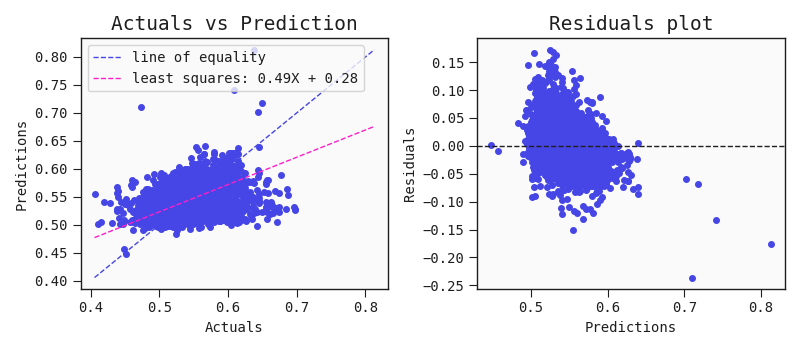
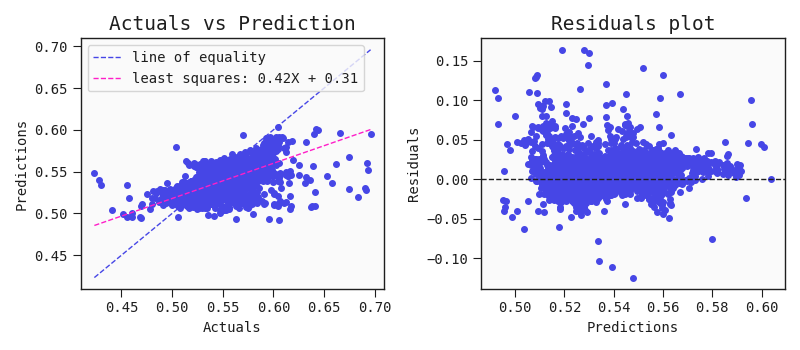

In [ ]:
summer_ch_sysef_df = summer_fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

summer_train, summer_test = split(summer_ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(summer_train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, summer_train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

summer_model = models[0]
summer_model.plot(
    data=summer_train,
    compare_data=summer_test
)

In [ ]:
root_mean_squared_error(summer_test['ch_sysef'], summer_model.predict(summer_test)) * 100

1.797757364543421

In [ ]:
interactive_activation_flow(summer_model, summer_train)

interactive(children=(FloatSlider(value=352.35703249999995, description='sys_cl', max=499.050262, min=205.6638…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

In [ ]:
rain_ch_sysef_df

,ch_sysef,lift,sys_cl,ct_tot_kw
675096,0.575967,24.488597,356.963501,7.040001
153280,0.591518,24.516353,348.486420,7.024000
42628,0.471652,24.852854,338.153748,7.136000
398610,0.463501,23.444030,289.665466,7.008000
408972,0.516840,22.627133,256.933624,7.088000
...,...,...,...,...
83284,0.497950,23.017419,349.175720,4.176000
226054,0.501974,23.014176,347.125793,4.136000
230478,0.510773,22.998265,342.931183,4.128000
230539,0.500252,23.026112,346.286865,4.128000


## Rain model

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="336.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 1009 336.0" width="1009" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="711" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="601" y="110.0"><title>ch_sysef
linear:
scale=0.149359
scale offset=0.000000
w=1.305545
bias=1.1140</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="646.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="689" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="603" y="119.0">out</text><line stroke="#1E1E1E" x1="571" x2="601" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="481" y="110.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="131.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="119.0">1</text><line stroke="#1E1E1E" x1="451" x2="481" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="451" x2="481" y1="157.5" y2="136.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="361" y="80.0"><title>sys_cl
linear:
scale=0.006686
scale offset=298.402059
w=0.451106
bias=1.7754</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="101.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="89.0">2</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="363" y="89.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="140.0"><title>add</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="161.5">add</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="149.0">3</text><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="148.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="157.5" y2="166.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="101.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="89.0">4</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="106.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="20.0"><title>lift
linear:
scale=0.102751
scale offset=22.967109
w=0.240203
bias=-0.5686</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">lift</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="123" y="29.0">num</text><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="80.0"><title>squared</title>
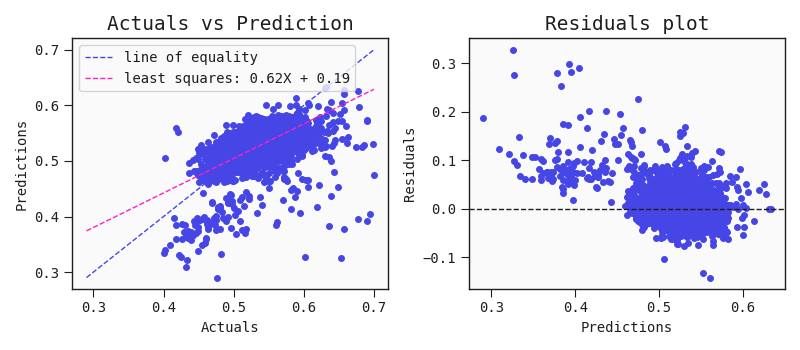
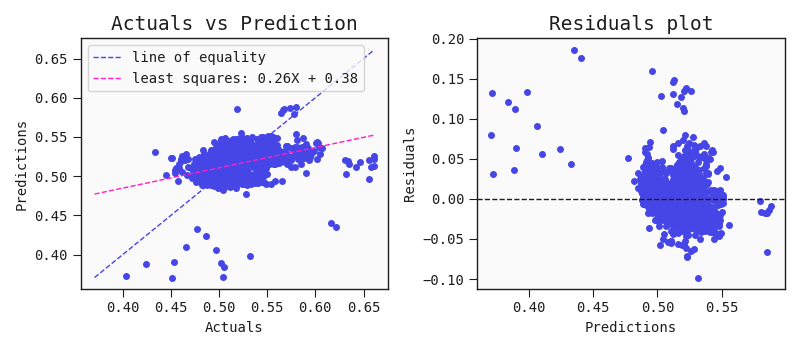

In [ ]:
rain_ch_sysef_df = rain_fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

rain_train, rain_test = split(rain_ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(rain_train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, rain_train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

rain_model = models[0]
rain_model.plot(
    data=rain_train,
    compare_data=rain_test
)

In [ ]:
root_mean_squared_error(rain_test['ch_sysef'], rain_model.predict(rain_test)) * 100

2.551609700841663

In [ ]:
interactive_activation_flow(rain_model, rain_train)

interactive(children=(FloatSlider(value=349.57592750000003, description='sys_cl', max=499.151306, min=200.0005…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

## Normal model

<?xml version="1.0" encoding="utf-8" ?>
<svg baseProfile="full" height="352.0" preserveAspectRatio="none" version="1.1" viewBox="0 0 875 352.0" width="875" xmlns="http://www.w3.org/2000/svg" xmlns:ev="http://www.w3.org/2001/xml-events" xmlns:xlink="http://www.w3.org/1999/xlink"><defs /><svg class="graph" height="275.0" width="591" x="0" y="0"><defs /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="481" y="110.0"><title>ch_sysef
linear:
scale=0.149456
scale offset=0.000000
w=2.879195
bias=3.2415</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="526.0" y="131.5">ch_sysef</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="569" y="119.0">0</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="483" y="119.0">out</text><line stroke="#1E1E1E" x1="451" x2="481" y1="127.5" y2="127.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="361" y="110.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="406.0" y="131.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="449" y="119.0">1</text><line stroke="#1E1E1E" x1="331" x2="361" y1="97.5" y2="118.5" /><line stroke="#1E1E1E" x1="331" x2="361" y1="157.5" y2="136.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="241" y="80.0"><title>multiply</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="286.0" y="101.5">multiply</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="329" y="89.0">2</text><line stroke="#1E1E1E" x1="211" x2="241" y1="37.5" y2="88.5" /><line stroke="#1E1E1E" x1="211" x2="241" y1="97.5" y2="106.5" /><rect class="node" fill="#FAFAFA" height="35" stroke="#FF1EC8" stroke-width="1" width="90" x="121" y="20.0"><title>gaussian</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="166.0" y="41.5">gaussian</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="209" y="29.0">3</text><line stroke="#1E1E1E" x1="91" x2="121" y1="37.5" y2="28.5" /><line stroke="#1E1E1E" x1="91" x2="121" y1="97.5" y2="46.5" /><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="20.0"><title>ct_tot_kw
linear:
scale=0.148280
scale offset=9.026207
w=0.516490
bias=0.8643</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="41.5">ct_tot_kw</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="29.0">4</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="29.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="1" y="80.0"><title>sys_cl
linear:
scale=0.006671
scale offset=321.278608
w=-2.407634
bias=-0.2937</title></rect><text fill="#1E1E1E" font-family="monospace" font-size="12" style="pointer-events:none" text-anchor="middle" x="46.0" y="101.5">sys_cl</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="end" x="89" y="89.0">5</text><text fill="#1E1E1E" font-family="monospace" font-size="10" style="pointer-events:none" text-anchor="start" x="3" y="89.0">num</text><rect class="node" fill="#00F082" height="35" stroke="#1E1E1E" stroke-width="1" width="90" x="121" y="80.0"><title>sys_cl

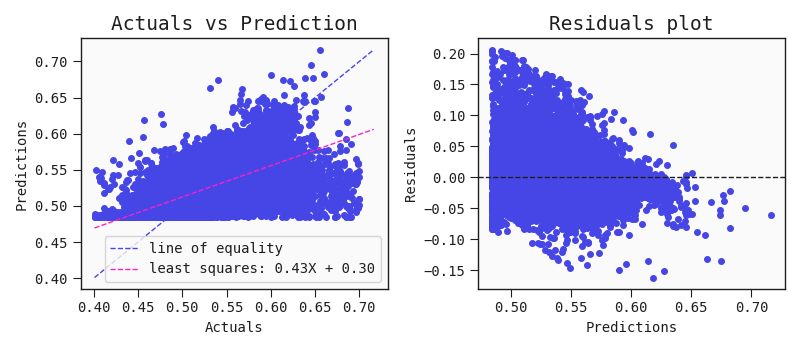
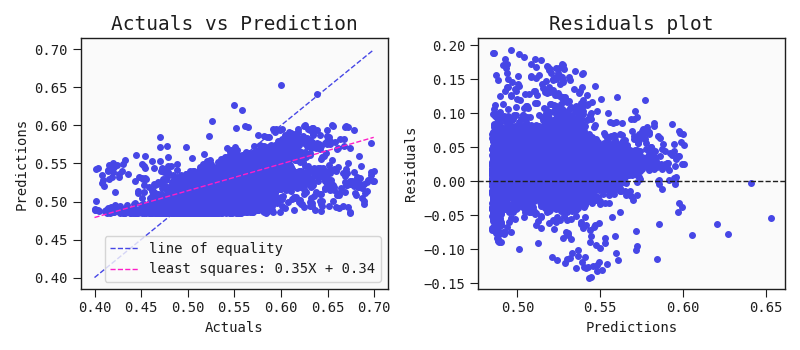

In [ ]:
normal_ch_sysef_df = fil_df[['ch_sysef', 'lift', 'sys_cl', 'ct_tot_kw']]

normal_train, normal_test = split(normal_ch_sysef_df, ratio=[0.8, 0.2], random_state=42)

ql = feyn.QLattice(random_seed=42)

models = ql.sample_models(normal_train.columns, 'ch_sysef', max_complexity=15)

models = feyn.fit_models(models, normal_train, 'absolute_error', 'bic')

models = feyn.prune_models(models)

models = feyn.get_diverse_models(
    models=models,
    n=10
)

normal_model = models[0]
normal_model.plot(
    data=normal_train,
    compare_data=normal_test
)

In [ ]:
root_mean_squared_error(normal_test['ch_sysef'], normal_model.predict(normal_test)) * 100

2.597793957948925

In [ ]:
interactive_activation_flow(normal_model, normal_train)

interactive(children=(FloatSlider(value=10.248001499999999, description='ct_tot_kw', max=16.992002999999997, m…

<function feyn.plots.interactive._graph_flow.interactive_activation_flow.<locals>.flow(**kwargs)>

In [ ]:
print(len(rain_ch_sysef_df), len(summer_ch_sysef_df), len(fil_df))

9906 28971 212449


In [ ]:
## save model
summer_model.save("summer_model.json")
rain_model.save("rain_model.json")
normal_model.save("normal_model.json")

NameError: name 'best' is not defined

In [ ]:
from feyn import Model

This version of Feyn and the QLattice is available for academic, personal, and non-commercial use. By using the community version of this software you agree to the terms and conditions which can be found at https://abzu.ai/eula.

In [ ]:
normal_model = Model.load("normal_model.json")

In [ ]:
res = []
for i in range(70,120,1):
    res.append(normal_model.predict({"ct_tot_kw": (i/10), "sys_cl": 400, "lift":22}))
print(res)

[0.544391436930287, 0.5442329959908593, 0.544066799688736, 0.543892779499303, 0.5437108795236021, 0.5435210582323131, 0.5433232902810942, 0.543117568386334, 0.5429039052484885, 0.5426823355082121, 0.5424529177185476, 0.5422157363145045, 0.5419709035594975, 0.541718561446386, 0.5414588835292772, 0.5411920766609248, 0.5409183826094771, 0.5406380795276006, 0.5403514832466408, 0.5400589483685555, 0.5397608691288787, 0.5394576800050066, 0.5391498560456327, 0.5388379128992216, 0.5385224065219976, 0.5382039325490049, 0.53788312531535, 0.5375606565187083, 0.537237233518511, 0.5369135972718428, 0.5365905199108995, 0.536268801971775, 0.5359492692892721, 0.5356327695772524, 0.5353201687186646, 0.5350123467936977, 0.5347101938784168, 0.5344146056496691, 0.5341264788349092, 0.5338467065478488, 0.5335761735524378, 0.5333157514985971, 0.5330662941733725, 0.532828632810745, 0.5326035715022719, 0.5323918827490781, 0.5321943031935286, 0.5320115295662593, 0.5318442148812099, 0.53169296490795]


In [ ]:
normal_model.predict({"ct_tot_kw": 11, "lift": 23, "sys_cl": 400})

0.5475389623131541